In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - gaiadr2-apogee_velocity_maps.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
This notebook will fit the velocity dispersions of 
'''

__author__ = "James Lane"

In [25]:
### Imports

## Basic
import numpy as np
import sys, os, pdb
import time
# import glob
# import subprocess

## Plotting
from matplotlib import pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib import colors
# from matplotlib import cm
# import aplpy

## Astropy
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import table
from astropy import units as apu
# from astropy import wcs
from astropy.coordinates import CartesianDifferential

## galpy & astroNN
# from galpy import orbit
# from galpy import potential
# from galpy.util import bovy_coords as gpcoords
import astroNN.apogee

## Scipy
from scipy.stats import binned_statistic_2d
from scipy.optimize import curve_fit

In [3]:
### Keywords
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Load premade catalog

In [5]:
### Load catalogs

gaiadr2_apogee_catalog = '../1-gaiadr2-apogee_dataset/gaiadr2-apogee_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

In [6]:
### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data['APOGEE_ID']
locid = data['LOCATION_ID']
gc_x = data['X']
gc_y = data['Y']
gc_z = data['Z']
gc_vx = data['VX']
gc_vy = data['VY']
gc_vz = data['VZ']

In [7]:
### Convert to galactocentric radius and radial velocity
gc_R = np.sqrt(np.square(gc_x)+np.square(gc_y))
gc_phi = np.arctan2(gc_y,gc_x)
gc_vR = np.cos(gc_phi)*gc_vx + np.sin(gc_phi)*gc_vy
gc_vT = -np.sin(gc_phi)*gc_vx + np.cos(gc_phi)*gc_vy


# Determine the dispersions and X

In [21]:
# Bin radially and calculate velocity dispersions
r_low = 3
r_hi = 15
bin_size = 0.5
n_bins = int(((r_hi-r_low)/bin_size)-1)
r_bins = np.arange(r_low,r_hi,bin_size)
r_bin_mids = r_bins[:-1]+(bin_size/2)
sigmavR = np.empty(n_bins)
sigmavT = np.empty(n_bins)
sigmavZ = np.empty(n_bins)
jk_sdvR = np.empty(n_bins)
jk_sdvT = np.empty(n_bins)
jk_sdvZ = np.empty(n_bins)

# Loop over all of the radial bins
for i in range(n_bins):
        
    # Find which stars are in this radial bin
    where_in_bin = np.where( (gc_R > r_bins[i]) & (gc_R < r_bins[i+1]) )[0]
    vR_temp = gc_vR[where_in_bin]
    vT_temp = gc_vT[where_in_bin]
    vZ_temp = gc_vz[where_in_bin]
    n_temp = len(where_in_bin)
    
    # Calculate standard deviations
    sigmavR[i] = np.std(vR_temp)
    sigmavT[i] = np.std(vT_temp)
    sigmavZ[i] = np.std(vZ_temp)
    
    # Do the jackknife error
    jk_sdvR_samps = np.empty(n_temp)
    jk_sdvT_samps = np.empty(n_temp)
    jk_sdvZ_samps = np.empty(n_temp)

    # Loop over the sample size
    for j in range(n_temp):
        
        # Drop 1 value out
        jk_vR_samp_temp = np.delete(vR_temp, j)
        jk_vT_samp_temp = np.delete(vT_temp, j)
        jk_vZ_samp_temp = np.delete(vZ_temp, j)
        
        # Calculate the SD of this sample.
        jk_sdvR_samps[j] = np.std(jk_vR_samp_temp)
        jk_sdvT_samps[j] = np.std(jk_vT_samp_temp)
        jk_sdvZ_samps[j] = np.std(jk_vZ_samp_temp)
        
    ###j
    
    # Calculate the standard error on the dispersion
    jk_sdvR[i] = np.sqrt( ((n_temp-1)/n_temp) * np.sum( np.square(jk_sdvR_samps - np.average(jk_sdvR_samps)) ) )
    jk_sdvT[i] = np.sqrt( ((n_temp-1)/n_temp) * np.sum( np.square(jk_sdvT_samps - np.average(jk_sdvT_samps)) ) )
    jk_sdvZ[i] = np.sqrt( ((n_temp-1)/n_temp) * np.sum( np.square(jk_sdvZ_samps - np.average(jk_sdvZ_samps)) ) )
    print('done '+str(i+1)+'/'+str(n_bins))
##i

done 1/23
done 2/23
done 3/23
done 4/23
done 5/23
done 6/23
done 7/23
done 8/23
done 9/23
done 10/23
done 11/23
done 12/23
done 13/23
done 14/23
done 15/23
done 16/23
done 17/23
done 18/23
done 19/23
done 20/23
done 21/23
done 22/23
done 23/23


# Fit exponentials

In [24]:
# Define the exponential fitting function
def exp_fitting_fn(x,A,h):
    return A*np.exp(-x/h)
#def

# Fit the radial dispersion
popt_vR, pcov_vR = curve_fit(exp_fitting_fn, r_bin_mids, sigmavR, sigma=jk_sdvR, p0=[100,30])
h_vR = popt_vR[1]
h_vR_err = np.sqrt(np.diag(pcov_vR))[1]

# Fit the circular dispersion
popt_vT, pcov_vT = curve_fit(exp_fitting_fn, r_bin_mids, sigmavT, sigma=jk_sdvT, p0=[100,30])
h_vT = popt_vT[1]
h_vT_err = np.sqrt(np.diag(pcov_vT))[1]

# Fit the Z dispersion
popt_vZ, pcov_vZ = curve_fit(exp_fitting_fn, r_bin_mids, sigmavZ, sigma=jk_sdvZ, p0=[100,30])
h_vZ = popt_vZ[1]
h_vZ_err = np.sqrt(np.diag(pcov_vZ))[1]

mock_radius = np.linspace(r_low, r_hi, num=1000)

print( r'Radial velocity dispersion at sun: '+str(exp_fitting_fn(8, popt_vR[0], popt_vR[1]) )+' km/s' )
print( r'Radial dispersion scale length: '+str(popt_vR[1])+' kpc\n')
print( r'Tangential velocity dispersion at sun: '+str(exp_fitting_fn(8, popt_vT[0], popt_vT[1]) )+' km/s' )
print( r'Tangential dispersion scale length: '+str(popt_vT[1])+' kpc\n')
print( r'Vertical velocity dispersion at sun: '+str(exp_fitting_fn(8, popt_vZ[0], popt_vZ[1]) )+' km/s' )
print( r'Vertical dispersion scale length: '+str(popt_vZ[1])+' kpc\n')

Radial velocity dispersion at sun: 45.869009579223196 (km/s)^2
Radial dispersion scale length: 9.838246031852773 kpc

Tangential velocity dispersion at sun: 40.22407589247307 (km/s)^2
Tangential dispersion scale length: 7.92610905745547 kpc

Vertical velocity dispersion at sun: 27.92667562662681 (km/s)^2
Vertical dispersion scale length: 7.664009479928688 kpc



# Plot individual dispersions and X

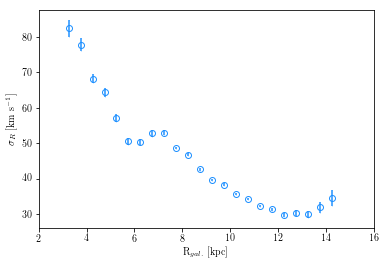

In [9]:
### Plot Radial velocity dispersion as a function of radius

fig = plt.figure()
ax = fig.add_subplot(111)

# ax.scatter(r_bin_mids, sigmavR, facecolor='None', edgecolor='DodgerBlue')
ax.errorbar(r_bin_mids, sigmavR, yerr=jk_sdvR, fmt='o', markerfacecolor='None', markeredgecolor='DodgerBlue',
           ecolor='DodgerBlue', capsize=0.1)
ax.set_xlim(r_low-1,r_hi+1)
ax.set_xlabel(r'R$_{gal.}$ [kpc]')
ax.set_ylabel(r'$\sigma_{R}$ [km s$^{-1}$]')

plt.show()
fig.savefig('r_vs_rsigma.pdf')
plt.close('all')

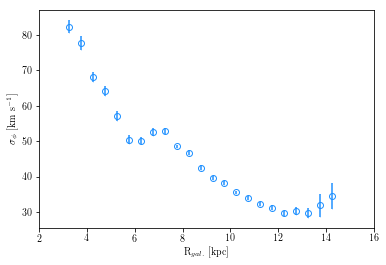

In [10]:
### Plot Radial velocity dispersion as a function of radius

fig = plt.figure()
ax = fig.add_subplot(111)

# ax.scatter(r_bin_mids, sigmavT, facecolor='None', edgecolor='DodgerBlue')
ax.errorbar(r_bin_mids, sigmavR, yerr=jk_sdvT, fmt='o', markerfacecolor='None', markeredgecolor='DodgerBlue',
           ecolor='DodgerBlue', capsize=0.1)
ax.set_xlim(r_low-1,r_hi+1)
ax.set_xlabel(r'R$_{gal.}$ [kpc]')
ax.set_ylabel(r'$\sigma_{\phi}$ [km s$^{-1}$]')

plt.show()
fig.savefig('r_vs_Tsigma.pdf')
plt.close('all')

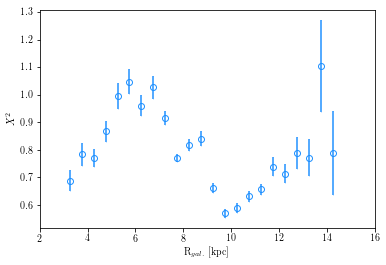

In [11]:
### Plot X as a function of radius

Xrat = np.divide(sigmavT**2,sigmavR**2)
# Figure out combined error
Xrat_err = Xrat * np.sqrt(2) * np.sqrt( np.square(jk_sdvT/sigmavT) + np.square(jk_sdvR/sigmavR) )

fig = plt.figure()
ax = fig.add_subplot(111)

# ax.scatter(r_bin_mids, Xrat, facecolor='None', edgecolor='DodgerBlue')
ax.errorbar(r_bin_mids, Xrat, yerr=Xrat_err, fmt='o', markerfacecolor='None', markeredgecolor='DodgerBlue',
           ecolor='DodgerBlue', capsize=0.1)
ax.set_xlim(r_low-1,r_hi+1)
ax.set_xlabel(r'R$_{gal.}$ [kpc]')
ax.set_ylabel(r'$X^{2}$')

plt.show()
fig.savefig('r_vs_X.pdf')
plt.close('all')

# Plot everything together

In [18]:
# Define the exponential fitting function
def exp_fitting_fn(x,A,h):
    return A*np.exp(-x/h)
#def

# Fit the radial dispersion
popt_vR, pcov_vR = curve_fit(exp_fitting_fn, r_bin_mids, sigmavR, sigma=jk_sdvR, p0=[100,30])
h_vR = popt_vR[1]
h_vR_err = np.sqrt(np.diag(pcov_vR))[1]

# Fit the circular dispersion
popt_vT, pcov_vT = curve_fit(exp_fitting_fn, r_bin_mids, sigmavT, sigma=jk_sdvT, p0=[100,30])
h_vT = popt_vT[1]
h_vT_err = np.sqrt(np.diag(pcov_vT))[1]

mock_radius = np.linspace(r_low, r_hi, num=1000)

print( r'Radial velocity dispersion at sun: '+str(exp_fitting_fn(8, popt_vR[0], popt_vR[1]) )+' (km/s)^2' )

Radial velocity dispersion at sun: 45.869009579223196 (km/s)^2


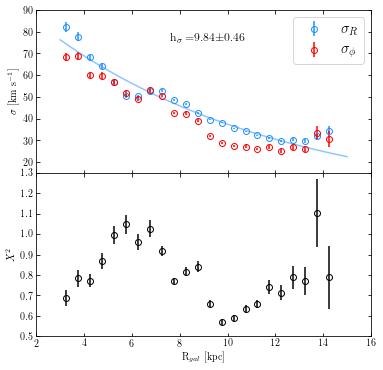

In [13]:
### Plot all together
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.errorbar(r_bin_mids, sigmavR, yerr=jk_sdvR, fmt='o', markerfacecolor='None',
             markeredgecolor='DodgerBlue', ecolor='DodgerBlue', label=r'$\sigma_{R}$')
ax1.plot(mock_radius, exp_fitting_fn(mock_radius, popt_vR[0], popt_vR[1]), linestyle='solid', color='DodgerBlue', alpha=0.5)

ax1.errorbar(r_bin_mids, sigmavT, yerr=jk_sdvT, fmt='o', markerfacecolor='None', 
             markeredgecolor='Red', ecolor='Red', label=r'$\sigma_{\phi}$')
# ax1.plot(mock_radius, exp_fitting_fn(mock_radius, popt_vT[0], popt_vT[1]), linestyle='solid', color='Red', alpha=0.5)

ax2.errorbar(r_bin_mids, Xrat, yerr=Xrat_err, fmt='o', markerfacecolor='None', 
             markeredgecolor='Black', ecolor='Black')

# ax1.scatter(r_bin_mids, sigmavR, facecolor='None', edgecolor='DodgerBlue', label=r'$\sigma_{R}$')
# ax1.scatter(r_bin_mids, sigmavT, facecolor='None', edgecolor='Red', label=r'$\sigma_{\phi}$')
# ax2.scatter(r_bin_mids, np.divide(sigmavT**2,sigmavR**2), facecolor='None', edgecolor='Black')

ax1.set_xlim(r_low-1,r_hi+1)
ax1.set_ylim(15,90)
ax2.set_xlim(r_low-1,r_hi+1)
ax2.set_ylim(0.5,1.3)

ax1.set_ylabel(r'$\sigma$ [km s$^{-1}$]')
ax2.set_xlabel(r'R$_{gal}$ [kpc]')
ax2.set_ylabel(r'$X^{2}$')

ax1.legend(loc='upper right', fontsize=15)
ax1.annotate(r'h$_{\sigma}=$'+str(round(h_vR,2))+r'$\pm$'+str(round(h_vR_err,2)), (0.4,0.8), 
             xycoords='axes fraction', fontsize=12)

ax1.tick_params(direction='in', right='on', top='on', labelbottom='off')
ax2.tick_params(direction='in', right='on', top='on', )

fig.subplots_adjust(hspace=0)

plt.show()
fig.savefig('vdisp_all.pdf')
plt.close('all')